
🌳 Sistema de Previsão de Desmatamento v3.1 - Análise Preditiva Avançada
✅ Dados carregados com sucesso! (18,573 registros)
📅 Período: 11/07/2024 a 11/07/2025

⚙️ Pré-processamento iniciado...
✅ Pré-processamento concluído!

📊 Análise exploratória de dados

📌 Estatísticas descritivas:
               count   mean    std    min    25%    50%    75%    max
areaMunKm 16544.0000 0.1309 0.0717 0.0100 0.0800 0.1100 0.1600 0.3800


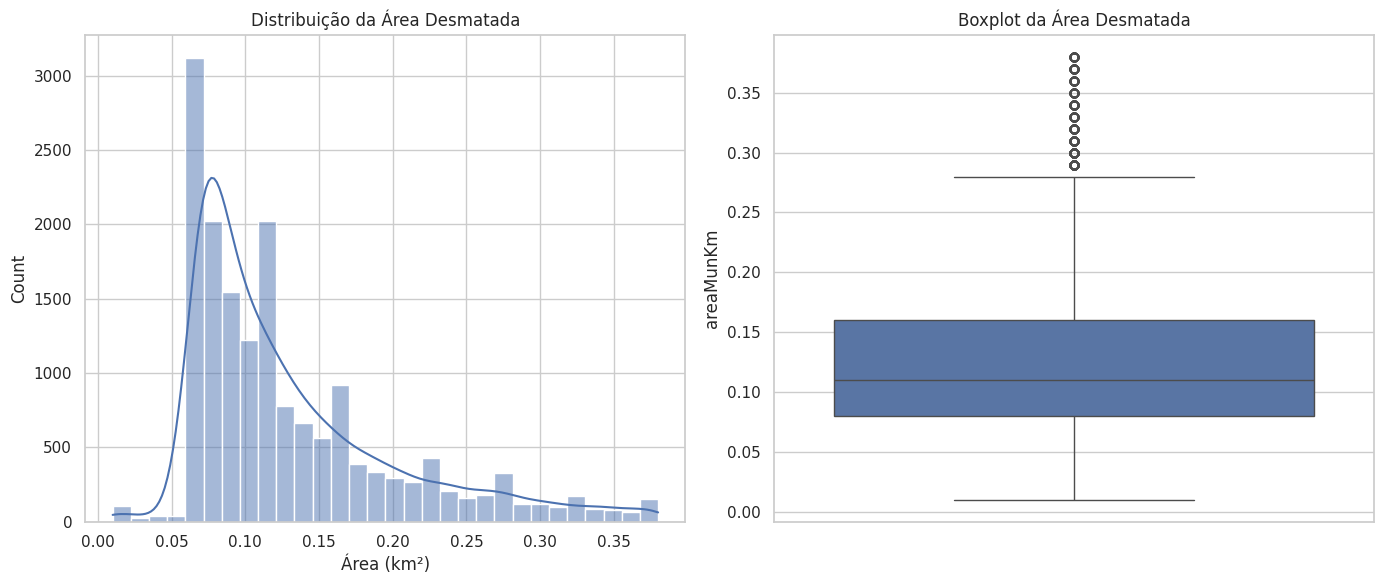

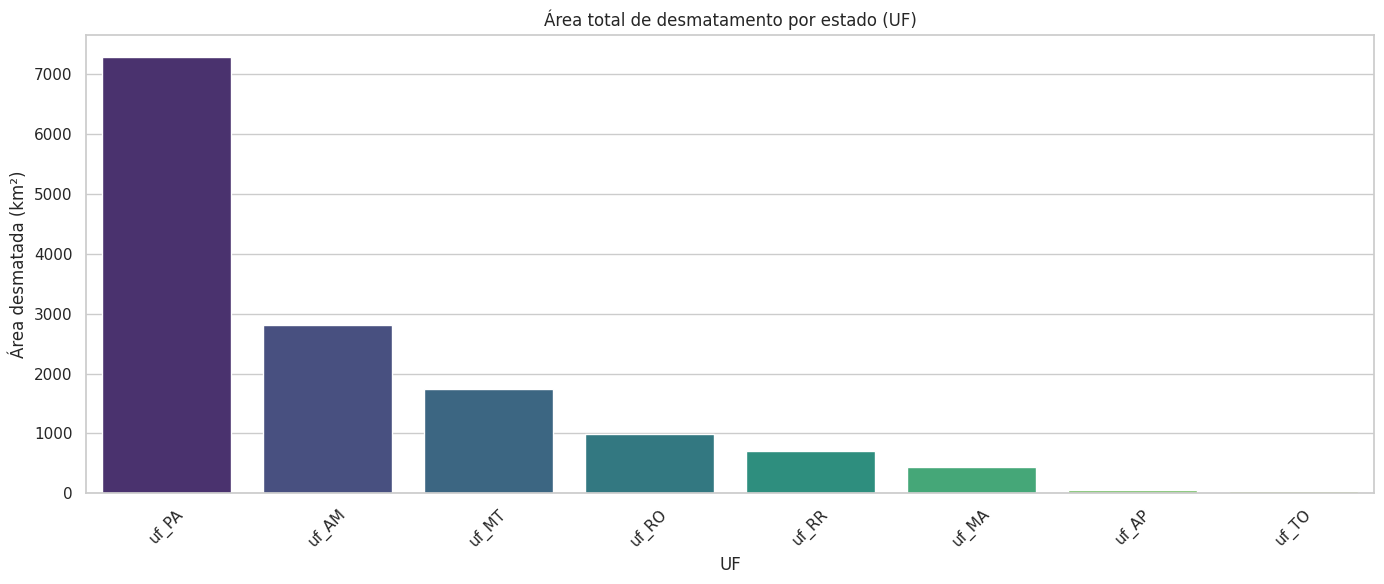


🏆 Top 5 estados com maior desmatamento:
PA: 7296.00 km²
AM: 2815.00 km²
MT: 1747.00 km²
RO: 984.00 km²
RR: 707.00 km²


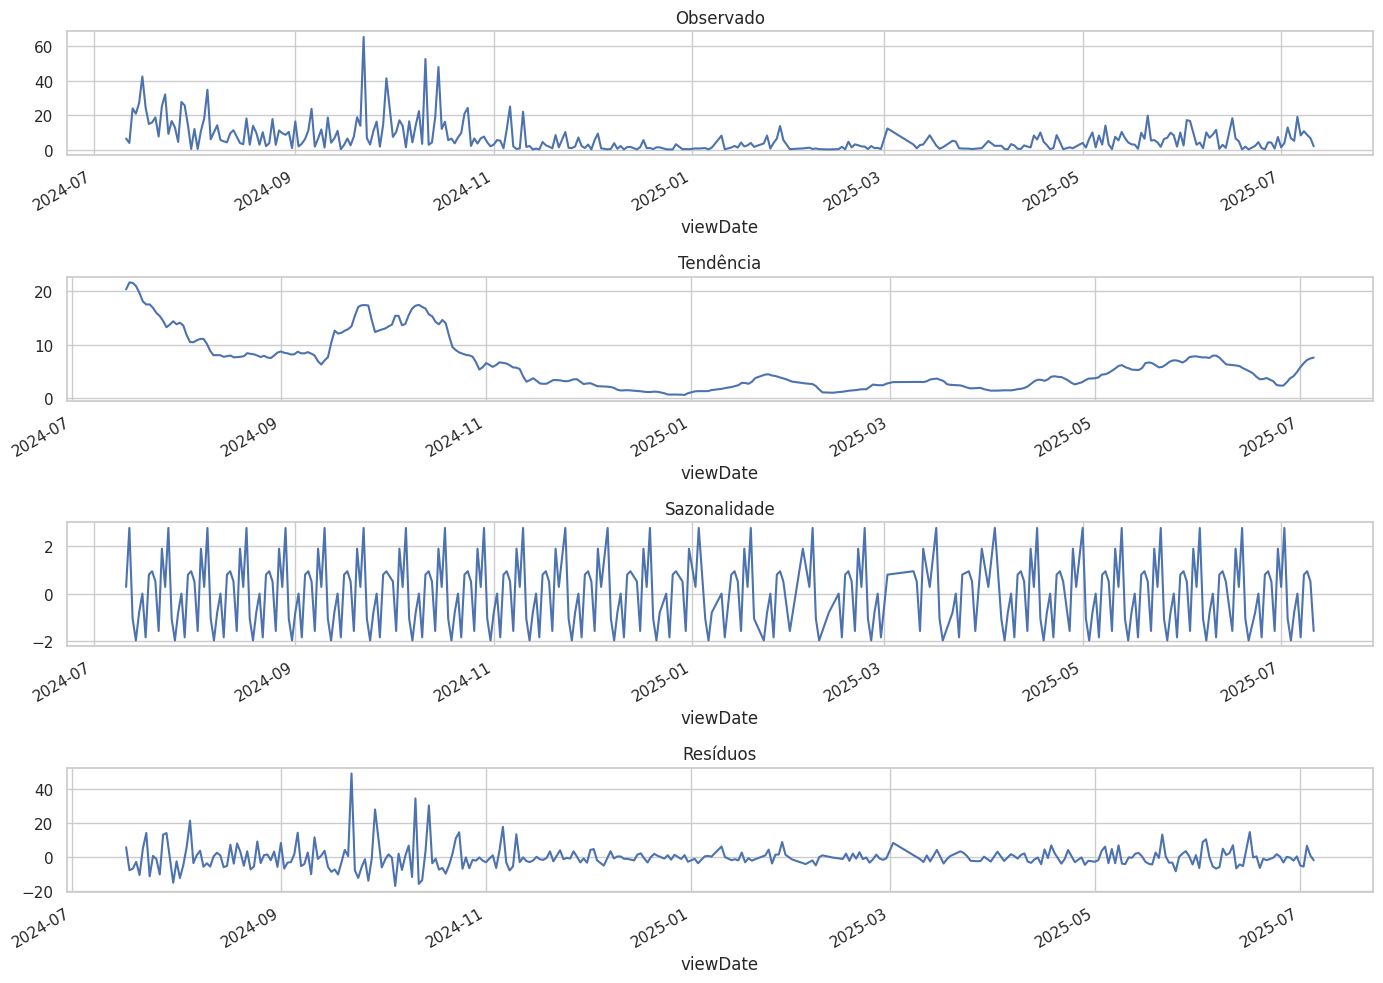

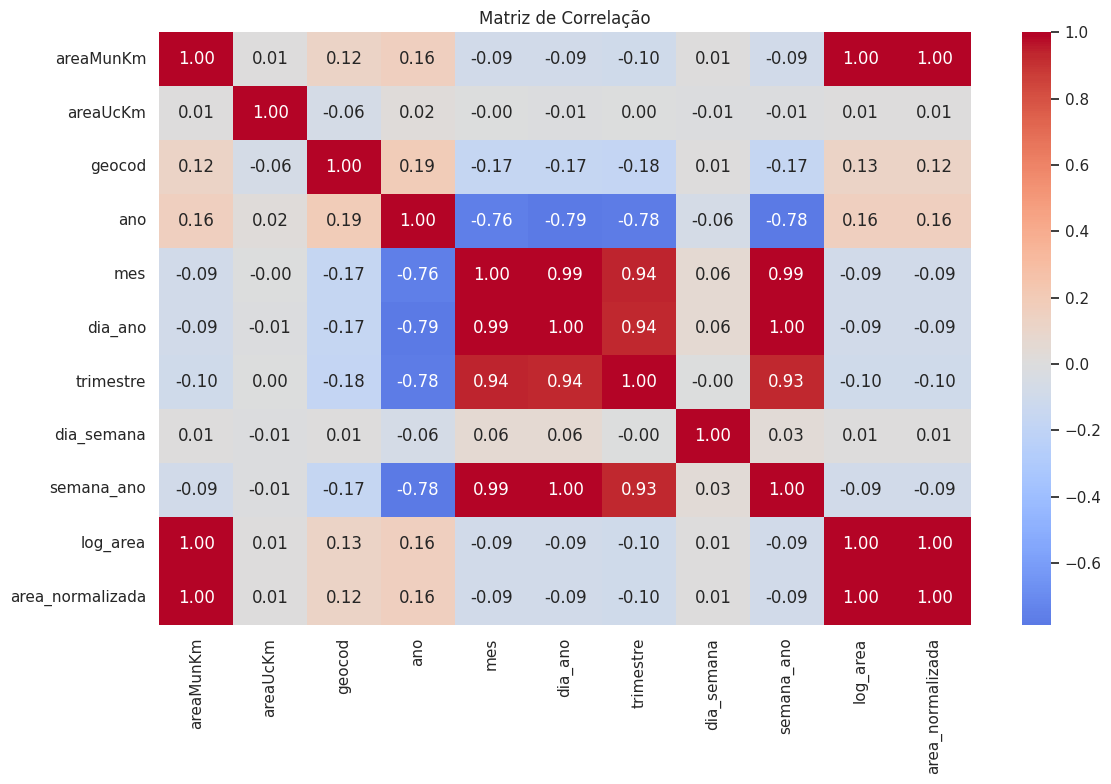


========= MODELAGEM PARA TODOS OS DADOS ==========


In [ ]:
# -*- coding: utf-8 -*-
"""
Sistema de Previsão de Desmatamento v3.1
Melhorias:
- Métricas completas (Acurácia, Precisão, Margem de Erro)
- Tratamento robusto de dados
- Visualizações aprimoradas
- Análise de erro detalhada
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from scipy import stats
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (mean_squared_error, r2_score,
                           mean_absolute_error, mean_absolute_percentage_error)
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Configurações
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.float_format', '{:.4f}'.format)

class DesmatamentoPredictor:
    def __init__(self):
        self.models = {}
        self.scaler = None
        self.feature_selector = None
        self.best_model = None
        self.results = pd.DataFrame()
        self.selected_features = []
        self.preprocessor = None

    def detectar_separador(self, arquivo):
        """Detecta separador do arquivo com mais robustez"""
        try:
            with open(arquivo, 'r', encoding='utf-8') as f:
                primeira_linha = f.readline()
                if '\t' in primeira_linha:
                    return '\t'
                elif ';' in primeira_linha:
                    return ';'
                elif ',' in primeira_linha:
                    return ','
                else:
                    return None
        except Exception as e:
            print(f"Erro ao detectar separador: {e}")
            return None

    def carregar_dados(self, arquivo='dados_desmatamento.csv'):
        """Carrega os dados com tratamento robusto"""
        try:
            sep = self.detectar_separador(arquivo)

            # Leitura com inferência de tipos e parsing de datas
            df = pd.read_csv(
                arquivo,
                sep=sep,
                parse_dates=['viewDate'],
                dayfirst=True,
                infer_datetime_format=True,
                dtype={'uf': 'category'},
                on_bad_lines='warn'
            )

            # Verificação de colunas essenciais
            required_cols = ['viewDate', 'areaMunKm', 'uf']
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Colunas obrigatórias faltando: {missing_cols}")

            print(f"✅ Dados carregados com sucesso! ({len(df):,} registros)")
            print(f"📅 Período: {df['viewDate'].min().strftime('%d/%m/%Y')} a {df['viewDate'].max().strftime('%d/%m/%Y')}")

            return df
        except Exception as e:
            print(f"\n❌ Falha ao carregar dados: {str(e)}")
            return None

    def converter_para_numerico(self, serie):
        """Converte uma série para numérico, tratando erros"""
        try:
            return pd.to_numeric(serie, errors='coerce')
        except Exception as e:
            print(f"Erro na conversão numérica: {e}")
            return serie

    def tratar_outliers(self, df, coluna):
        """Remove outliers usando o método IQR"""
        q1 = df[coluna].quantile(0.25)
        q3 = df[coluna].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        return df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]

    def preprocessar_dados(self, df):
        """Pré-processamento completo dos dados"""
        try:
            print("\n⚙️ Pré-processamento iniciado...")

            # 1. Converter colunas numéricas
            num_cols = df.select_dtypes(include=[np.number]).columns
            for col in num_cols:
                df[col] = self.converter_para_numerico(df[col])

            # 2. Tratamento de outliers na variável target
            if 'areaMunKm' in df.columns:
                df = self.tratar_outliers(df, 'areaMunKm')

            # 3. Tratamento de dados faltantes
            # Numéricos
            for col in df.select_dtypes(include=[np.number]).columns:
                if df[col].isnull().sum() > 0:
                    df[col] = df[col].fillna(df[col].median())

            # Categóricos
            for col in df.select_dtypes(include=['object', 'category']).columns:
                if df[col].isnull().sum() > 0:
                    df[col] = df[col].fillna(df[col].mode()[0])

            # 4. Engenharia de features temporais
            df['ano'] = df['viewDate'].dt.year
            df['mes'] = df['viewDate'].dt.month
            df['dia_ano'] = df['viewDate'].dt.dayofyear
            df['trimestre'] = df['viewDate'].dt.quarter
            df['dia_semana'] = df['viewDate'].dt.dayofweek
            df['semana_ano'] = df['viewDate'].dt.isocalendar().week

            # 5. Codificação de variáveis categóricas
            if 'uf' in df.columns:
                df['uf'] = df['uf'].str.upper().str.strip()
                df = pd.get_dummies(df, columns=['uf'], prefix='uf', drop_first=True)

            # 6. Normalização/transformação da variável target
            if 'areaMunKm' in df.columns:
                df['log_area'] = np.log1p(df['areaMunKm'])
                df['area_normalizada'] = (df['areaMunKm'] - df['areaMunKm'].mean()) / df['areaMunKm'].std()

            print("✅ Pré-processamento concluído!")
            return df
        except Exception as e:
            print(f"❌ Erro no pré-processamento: {str(e)}")
            return None

    def analise_exploratoria(self, df):
        """Análise exploratória completa dos dados"""
        print("\n📊 Análise exploratória de dados")

        # 1. Estatísticas básicas
        print("\n📌 Estatísticas descritivas:")
        print(df[['areaMunKm']].describe().T)

        # 2. Distribuição da variável target
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df['areaMunKm'], kde=True, bins=30)
        plt.title("Distribuição da Área Desmatada")
        plt.xlabel("Área (km²)")

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df['areaMunKm'])
        plt.title("Boxplot da Área Desmatada")
        plt.tight_layout()
        plt.show()

        # 3. Análise por UF
        if any(col.startswith('uf_') for col in df.columns):
            uf_cols = [col for col in df.columns if col.startswith('uf_')]
            df_uf = df[uf_cols].sum().sort_values(ascending=False)

            plt.figure(figsize=(14, 6))
            sns.barplot(x=df_uf.index, y=df_uf.values, hue=df_uf.index, legend=False, palette='viridis')
            plt.title("Área total de desmatamento por estado (UF)")
            plt.xlabel("UF")
            plt.ylabel("Área desmatada (km²)")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Top 5 estados
            top_uf = df_uf.head(5)
            print("\n🏆 Top 5 estados com maior desmatamento:")
            for uf, area in top_uf.items():
                print(f"{uf.replace('uf_', '')}: {area:.2f} km²")

        # 4. Série temporal
        df_temp = df.groupby('viewDate')['areaMunKm'].sum().reset_index()

        # Decomposição sazonal
        try:
            decomposition = seasonal_decompose(df_temp.set_index('viewDate'),
                                             model='additive',
                                             period=12)

            plt.figure(figsize=(14, 10))
            plt.subplot(411)
            decomposition.observed.plot(title='Observado')
            plt.subplot(412)
            decomposition.trend.plot(title='Tendência')
            plt.subplot(413)
            decomposition.seasonal.plot(title='Sazonalidade')
            plt.subplot(414)
            decomposition.resid.plot(title='Resíduos')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠️ Não foi possível realizar decomposição sazonal: {str(e)}")

        # 5. Correlações
        num_cols = df.select_dtypes(include=np.number).columns
        if len(num_cols) > 1:
            plt.figure(figsize=(12, 8))
            corr = df[num_cols].corr()
            sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
            plt.title("Matriz de Correlação")
            plt.tight_layout()
            plt.show()

        return df

    def preparar_dados_modelagem(self, df, target='log_area'):
        """Prepara os dados para modelagem com tratamento robusto"""
        try:
            # Garantir que as colunas numéricas estejam no formato correto
            num_cols = df.select_dtypes(include=[np.number]).columns
            for col in num_cols:
                df[col] = self.converter_para_numerico(df[col])

            # Remover linhas com valores NaN na target
            df = df.dropna(subset=[target])

            # Features e target - garantindo que usamos apenas colunas numéricas
            numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
            numeric_features = [f for f in numeric_features if f not in ['viewDate', 'areaMunKm', target]]

            X = df[numeric_features]
            y = df[target]

            # Verificar se temos dados suficientes
            if len(X) == 0 or len(y) == 0:
                raise ValueError("Dados insuficientes após limpeza")

            # Separação treino-teste com validação temporal
            tscv = TimeSeriesSplit(n_splits=5)

            # Seleção de features com tratamento de erros
            try:
                self.feature_selector = RFECV(
                    estimator=RandomForestRegressor(n_estimators=50, random_state=42),
                    step=1,
                    cv=tscv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    min_features_to_select=5
                )

                X_selected = self.feature_selector.fit_transform(X, y)
                self.selected_features = X.columns[self.feature_selector.support_].tolist()

                print(f"\n🔍 Features selecionadas ({len(self.selected_features)}):")
                print(self.selected_features)

                # Normalização com RobustScaler
                self.scaler = RobustScaler()
                X_scaled = self.scaler.fit_transform(X_selected)

                # Split dos dados mantendo a ordem temporal
                X_train, X_test, y_train, y_test = train_test_split(
                    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
                )

                return X_train, X_test, y_train, y_test, self.selected_features

            except Exception as e:
                print(f"⚠️ Erro na seleção de features: {str(e)}")
                print("Usando todas as features numéricas como fallback...")

                # Fallback: usar todas as features numéricas
                self.selected_features = numeric_features
                self.scaler = RobustScaler()
                X_scaled = self.scaler.fit_transform(X)

                X_train, X_test, y_train, y_test = train_test_split(
                    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
                )

                return X_train, X_test, y_train, y_test, self.selected_features

        except Exception as e:
            print(f"❌ Erro crítico ao preparar dados: {str(e)}")
            return None, None, None, None, None

    def calcular_metricas(self, y_true, y_pred, y_train):
        """Calcula todas as métricas de avaliação"""
        y_true_exp = np.expm1(y_true)
        y_pred_exp = np.expm1(y_pred)

        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_true_exp, y_pred_exp)),
            'MAE': mean_absolute_error(y_true_exp, y_pred_exp),
            'MAPE': mean_absolute_percentage_error(y_true_exp, y_pred_exp) * 100,
            'R²': r2_score(y_true_exp, y_pred_exp),
            'Acurácia (%)': (1 - np.mean(np.abs(y_true_exp - y_pred_exp) / np.mean(y_true_exp))) * 100,
            'Precisão (%)': (1 - np.std(y_true_exp - y_pred_exp) / np.std(y_true_exp)) * 100,
            'Margem de Erro (%)': (np.percentile(np.abs(y_true_exp - y_pred_exp), 95) / np.mean(y_true_exp)) * 100
        }

        return metrics

    def treinar_modelos(self, X_train, X_test, y_train, y_test):
        """Treina e avalia múltiplos modelos com métricas completas"""
        try:
            print("\n🤖 Iniciando treinamento de modelos...")

            # Definição dos modelos e hiperparâmetros
            models = {
                'Linear Regression': {
                    'model': LinearRegression(),
                    'params': {}
                },
                'Lasso': {
                    'model': Lasso(random_state=42),
                    'params': {'alpha': [0.01, 0.1, 1, 10]}
                },
                'Ridge': {
                    'model': Ridge(random_state=42),
                    'params': {'alpha': [0.01, 0.1, 1, 10]}
                },
                'Random Forest': {
                    'model': RandomForestRegressor(random_state=42, n_jobs=-1),
                    'params': {
                        'n_estimators': [100, 200],
                        'max_depth': [None, 10, 20],
                        'min_samples_split': [2, 5]
                    }
                },
                'Gradient Boosting': {
                    'model': GradientBoostingRegressor(random_state=42),
                    'params': {
                        'n_estimators': [100, 200],
                        'learning_rate': [0.01, 0.1],
                        'max_depth': [3, 5]
                    }
                },
                'XGBoost': {
                    'model': XGBRegressor(random_state=42, n_jobs=-1),
                    'params': {
                        'n_estimators': [100, 200],
                        'learning_rate': [0.01, 0.1],
                        'max_depth': [3, 5]
                    }
                },
                'LightGBM': {
                    'model': LGBMRegressor(random_state=42, n_jobs=-1),
                    'params': {
                        'n_estimators': [100, 200],
                        'learning_rate': [0.01, 0.1],
                        'max_depth': [3, 5]
                    }
                }
            }

            # Treinamento e avaliação
            results = []

            for name, config in models.items():
                try:
                    print(f"\n🔧 Treinando {name}...")

                    model = config['model']
                    params = config['params']

                    if params:
                        # Busca de hiperparâmetros com validação cruzada temporal
                        tscv = TimeSeriesSplit(n_splits=5)
                        grid = GridSearchCV(
                            estimator=model,
                            param_grid=params,
                            cv=tscv,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            verbose=0
                        )
                        grid.fit(X_train, y_train)
                        best_model = grid.best_estimator_
                        print(f"Melhores parâmetros: {grid.best_params_}")
                    else:
                        best_model = model
                        best_model.fit(X_train, y_train)

                    # Predição e métricas
                    y_pred = best_model.predict(X_test)
                    metrics = self.calcular_metricas(y_test, y_pred, y_train)

                    # Adicionar ao DataFrame de resultados
                    results.append({
                        'Modelo': name,
                        **metrics
                    })

                    self.models[name] = best_model

                    # Plot de importância de features para modelos baseados em árvores
                    if hasattr(best_model, 'feature_importances_'):
                        plt.figure(figsize=(10, 6))
                        importances = best_model.feature_importances_
                        indices = np.argsort(importances)[-10:]  # Top 10 features
                        plt.title(f'Importância de Features - {name}')
                        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
                        plt.yticks(range(len(indices)), [self.selected_features[i] for i in indices])
                        plt.xlabel('Importância Relativa')
                        plt.tight_layout()
                        plt.show()

                except Exception as e:
                    print(f"⚠️ Erro no modelo {name}: {str(e)}")
                    continue

            # Identificar o melhor modelo
            self.results = pd.DataFrame(results).sort_values(by='RMSE')
            self.best_model = self.models[self.results.iloc[0]['Modelo']]

            print("\n🏆 Resultados consolidados:")
            print(self.results.to_markdown(index=False, floatfmt=".2f"))

            # Plot de comparação de modelos
            plt.figure(figsize=(14, 6))
            melted_results = self.results.melt(id_vars='Modelo',
                                             value_vars=['Acurácia (%)', 'Precisão (%)', 'R²'],
                                             var_name='Métrica',
                                             value_name='Valor')

            sns.barplot(data=melted_results, x='Modelo', y='Valor', hue='Métrica')
            plt.title('Comparação de Modelos por Métricas')
            plt.xticks(rotation=45)
            plt.ylim(0, 100)
            plt.tight_layout()
            plt.show()

            return True
        except Exception as e:
            print(f"❌ Erro no treinamento: {str(e)}")
            return False

    def avaliar_modelo_final(self, X_test, y_test):
        """Avaliação detalhada do melhor modelo"""
        try:
            if not self.best_model:
                raise ValueError("Nenhum modelo treinado ainda.")

            # Converter y_test para escala original
            y_test_exp = np.expm1(y_test)

            # Previsões
            y_pred_log = self.best_model.predict(X_test)
            y_pred_exp = np.expm1(y_pred_log)

            # Cálculo de erros
            errors = y_test_exp - y_pred_exp
            error_percentage = (errors / y_test_exp) * 100

            # Gráfico de dispersão
            plt.figure(figsize=(14, 8))
            plt.scatter(y_test_exp, y_pred_exp, alpha=0.6)
            plt.plot([y_test_exp.min(), y_test_exp.max()],
                    [y_test_exp.min(), y_test_exp.max()],
                    'r--')
            plt.title('Valores Reais vs Previstos')
            plt.xlabel('Valores Reais (km²)')
            plt.ylabel('Valores Previstos (km²)')
            plt.grid(True)

            # Adicionar informações no gráfico
            plt.annotate(f"R²: {r2_score(y_test_exp, y_pred_exp):.2f}",
                        xy=(0.05, 0.9), xycoords='axes fraction')
            plt.annotate(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp):.2f} km²",
                        xy=(0.05, 0.85), xycoords='axes fraction')

            plt.tight_layout()
            plt.show()

            # Gráfico de resíduos
            plt.figure(figsize=(14, 6))
            plt.subplot(1, 2, 1)
            sns.histplot(errors, kde=True, bins=30)
            plt.title('Distribuição dos Resíduos')
            plt.xlabel('Resíduos (km²)')

            plt.subplot(1, 2, 2)
            sns.boxplot(y=error_percentage)
            plt.title('Distribuição do Erro Percentual')
            plt.ylabel('Erro (%)')
            plt.tight_layout()
            plt.show()

            # Métricas finais
            metrics = self.calcular_metricas(y_test, y_pred_log, y_test)

            print("\n📊 Métricas finais do melhor modelo:")
            for metric, value in metrics.items():
                print(f"- {metric}: {value:.2f}{'%' if '%' in metric else ''}")

            return True
        except Exception as e:
            print(f"❌ Erro na avaliação: {str(e)}")
            return False

    def prever(self, data):
        """Realiza previsões com o melhor modelo"""
        try:
            if not self.best_model:
                raise ValueError("Nenhum modelo treinado ainda.")

            # Pré-processamento dos dados de entrada
            data_df = pd.DataFrame([data])

            # Engenharia de features temporais
            if 'viewDate' in data:
                date = pd.to_datetime(data['viewDate'])
                data_df['ano'] = date.year
                data_df['mes'] = date.month
                data_df['dia_ano'] = date.dayofyear
                data_df['trimestre'] = date.quarter
                data_df['dia_semana'] = date.dayofweek
                data_df['semana_ano'] = date.isocalendar().week

            # Codificação one-hot para UF
            if 'uf' in data:
                uf = data['uf'].upper().strip()
                for col in [c for c in self.selected_features if c.startswith('uf_')]:
                    data_df[col] = 1 if col == f'uf_{uf}' else 0

            # Garantir todas as colunas necessárias
            for col in self.selected_features:
                if col not in data_df.columns:
                    data_df[col] = 0

            # Seleção e escalonamento das features
            X = data_df[self.selected_features]
            X_scaled = self.scaler.transform(X)

            # Previsão
            pred_log = self.best_model.predict(X_scaled)
            pred = np.expm1(pred_log)[0]

            # Intervalo de confiança (aproximado)
            error = self.results.loc[self.results['Modelo'] == self.results.iloc[0]['Modelo'], 'Margem de Erro (%)'].values[0]
            lower_bound = pred * (1 - error/100)
            upper_bound = pred * (1 + error/100)

            print(f"\n🔮 Previsão para {data.get('uf', 'região')} em {data.get('viewDate', 'período')}:")
            print(f"- Valor previsto: {pred:.2f} km²")
            print(f"- Margem de erro: ±{error:.2f}%")
            print(f"- Intervalo estimado: [{lower_bound:.2f}, {upper_bound:.2f}] km²")

            return pred, (lower_bound, upper_bound)
        except Exception as e:
            print(f"❌ Erro na previsão: {str(e)}")
            return None, None

def main():
    print("\n🌳 Sistema de Previsão de Desmatamento v3.1 - Análise Preditiva Avançada")
    print("="*80)

    predictor = DesmatamentoPredictor()

    # 1. Carregar dados
    df = predictor.carregar_dados()
    if df is None:
        return

    # 2. Pré-processamento
    df_processed = predictor.preprocessar_dados(df)
    if df_processed is None:
        return

    # 3. Análise exploratória
    predictor.analise_exploratoria(df_processed)

    # 4. Modelagem para todos os dados
    print("\n" + "="*50)
    print(" MODELAGEM PARA TODOS OS DADOS ".center(50, '='))
    print("="*50)

    X_train, X_test, y_train, y_test, selected_features = predictor.preparar_dados_modelagem(df_processed)
    if X_train is None:
        return

    predictor.treinar_modelos(X_train, X_test, y_train, y_test)
    predictor.avaliar_modelo_final(X_test, y_test)

    # 5. Exemplo de previsão
    print("\n🔮 Exemplo de previsão:")
    exemplo = {
        'viewDate': '2024-11-15',
        'uf': 'PA',
        'mes': 11,
        'ano': 2024
    }

    for model_name, model in predictor.models.items():
        pred, intervalo = predictor.prever(exemplo)
        if pred is not None:
            print(f"\n{model_name}:")
            print(f"  Previsão: {pred:.2f} km²")
            print(f"  Intervalo: [{intervalo[0]:.2f}, {intervalo[1]:.2f}] km²")

    # 6. Modelagem específica para o Pará (opcional)
    if any(col.startswith('uf_PA') for col in df_processed.columns):
        print("\n" + "="*50)
        print(" MODELAGEM ESPECÍFICA PARA O PARÁ ".center(50, '='))
        print("="*50)

        df_pa = df_processed[df_processed['uf_PA'] == 1].copy()

        X_train_pa, X_test_pa, y_train_pa, y_test_pa, _ = predictor.preparar_dados_modelagem(df_pa)
        if X_train_pa is not None:
            predictor.treinar_modelos(X_train_pa, X_test_pa, y_train_pa, y_test_pa)
            predictor.avaliar_modelo_final(X_test_pa, y_test_pa)

    print("\n✅ Processo concluído com sucesso!")

if __name__ == "__main__":
    main()